In [1]:
import functools
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import torch
from tqdm.auto import trange

sys.path.append("..")

from trajectory import IsDivergingPrecise, compare_trajectory, plot_trajectory

from common import fitting
from common.hyperparameter import HyperParameter
from common.path import DATA_DIR, FIG_DIR, RESULT_DIR
from modules.utils import prune_state_dict
from train.scheduler import get_scheduler
from train.trainer import rollout
from modules import RungeKutta
from .approximator import RosslerApproximator

In [2]:
device = torch.device("cuda:0")
# exp_id = "pu5otomn"
exp_id = "best_RK"
test_id = "RK4_test"

result_dir = RESULT_DIR / f"rossler_{exp_id}"

# Load hyperparameter
hp = HyperParameter.from_yaml(result_dir / "hyperparameter.yaml")


# Load checkpoint
checkpoint = torch.load(result_dir / "best.pth", map_location=device)

# Load MAE
mae_df = pd.read_csv(result_dir / "mae.txt", sep="\t")
train_mae, val_mae = mae_df["train_mae"], mae_df["val_mae"]
rollout_mae = mae_df["rollout_mae"]
best_epoch = np.argmin(rollout_mae).item()

# Load data
test_df = pd.read_pickle(DATA_DIR / f"rossler_{test_id}.pkl")

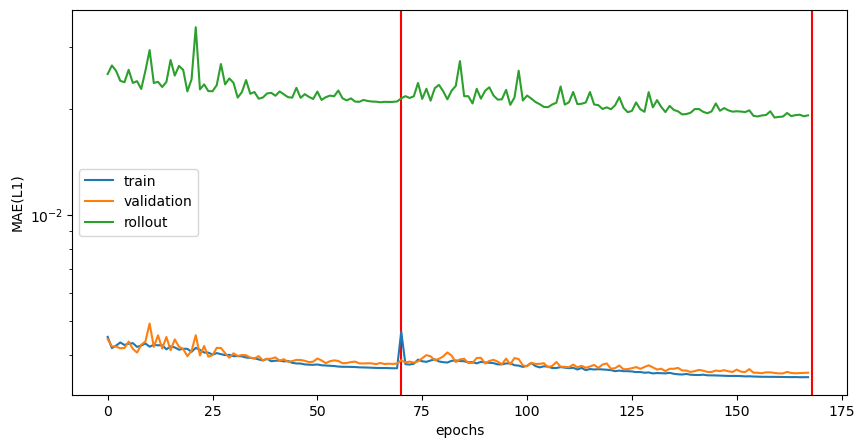

In [3]:
# Plot train history
fig, ax = plt.subplots(figsize=(10, 5))

schedular = get_scheduler(hp.scheduler)
for cycle in schedular.get_updated_epochs(hp.scheduler, len(train_mae)):
    plt.axvline(cycle, color="r")

ax.plot(train_mae, label="train")
ax.plot(val_mae, label="validation")
ax.plot(rollout_mae, label="rollout")
ax.set_xlabel("epochs")
ax.set_ylabel("MAE(L1)")
ax.set_yscale("log")
ax.legend()

fig.show()

In [ ]:
approximator = RosslerApproximator.from_hp(hp.approximator)
approximator.load_state_dict(prune_state_dict(checkpoint["best_model_state_dict"]))
# model = RungeKutta(approximator, butcher_tableau=hp.rk).to(device)
model = RungeKutta(approximator, butcher_tableau="rk4").to(device)

rossler_rollout = functools.partial(
    rollout,
    model=model,
    use_amp=hp.amp,
    device=device,
    is_diverging=IsDivergingPrecise(),
)


# Rollout

In [4]:
pred_trajectories: list[npt.NDArray[np.float32]] = []
for idx in trange(len(test_df)):
    pred_trajectories.append(rossler_rollout(series=test_df.iloc[idx]).cpu().numpy())

  0%|          | 0/40 [00:00<?, ?it/s]

In [1]:
# with open(result_dir / f"pred_{test_id}.pkl", "wb") as f:
#     pickle.dump(pred_trajectories, f)

with open(result_dir / f"pred_{test_id}.pkl", "rb") as f:
    pred_trajectories = pickle.load(f)

NameError: name 'result_dir' is not defined

# Analyze

In [4]:
times = np.array(
    [np.append(0, np.cumsum(dts.numpy(), dtype=np.float32)) for dts in test_df.dts],
    dtype=np.float32,
)
true_trajectories = [traj.numpy() for traj in test_df.trajectories]

maes = []
for idx, (true, pred) in enumerate(zip(true_trajectories, pred_trajectories)):
    print(f"{idx=}, {test_df.network_type[idx]}, N={true.shape[1]}", end=" ")
    maes.append(compare_trajectory(true, pred))
maes = np.stack(maes, axis=0)  # (# of samples, S)
print(f"Error: MAE={np.mean(maes):.4e} \t std={np.std(maes):.4e}")

idx=0, rr, N=10000 MAE: 0.0072, Maximum err: 0.0940 at step=791, node=6096, coordinate=x
idx=1, ba, N=10000 MAE: 0.0099, Maximum err: 1.5911 at step=72, node=0, coordinate=x
idx=2, rr, N=10000 MAE: 0.0070, Maximum err: 0.0868 at step=790, node=1958, coordinate=x
idx=3, ba, N=10000 MAE: 0.0094, Maximum err: 2.2468 at step=47, node=0, coordinate=x
idx=4, er, N=8367 MAE: 0.0098, Maximum err: 0.3129 at step=777, node=3969, coordinate=z
idx=5, er, N=9989 MAE: 0.0094, Maximum err: 0.1986 at step=793, node=6379, coordinate=y
idx=6, rr, N=10000 MAE: 0.0105, Maximum err: 0.2923 at step=779, node=3709, coordinate=z
idx=7, er, N=8608 MAE: 0.0194, Maximum err: 1.1422 at step=791, node=5610, coordinate=z
idx=8, er, N=9427 MAE: 0.0108, Maximum err: 0.5837 at step=798, node=7794, coordinate=z
idx=9, ba, N=10000 MAE: 0.0137, Maximum err: 0.3985 at step=714, node=3, coordinate=x
idx=10, rr, N=10000 MAE: 0.0113, Maximum err: 0.1145 at step=791, node=7931, coordinate=x
idx=11, rr, N=10000 MAE: 0.0140, Ma

## Single sample

In [6]:
sample_idx = 1

print(test_df.network_type[sample_idx])
xticks = np.round(np.linspace(0, times[sample_idx, -1], 5), 2)
time = times[sample_idx]
true_trajcetory = true_trajectories[sample_idx]
pred_trajectory = pred_trajectories[sample_idx]
error = true_trajcetory - pred_trajectory
percentage_error = error / true_trajcetory

ba


plot node with index: [ 726 5599 9055  898 8581]


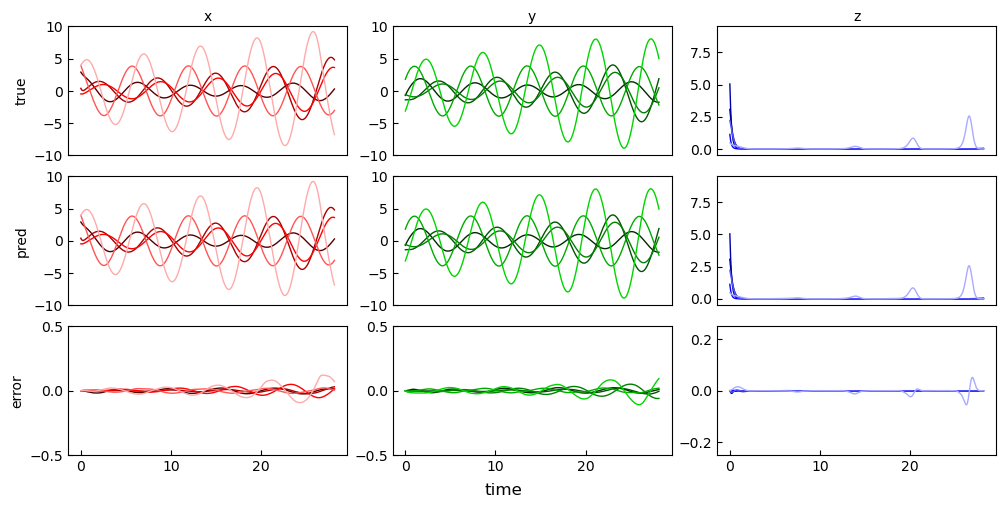

In [7]:
nodes = np.random.choice(np.arange(true_trajcetory.shape[1]), 5, replace=False)
# nodes = set()
# for idx in np.argsort(np.abs(percentage_error).sum(axis=0).flatten())[::-1]:  # max
# # for idx in np.argsort(np.abs(percentage_error).sum(axis=0).flatten()):    # min
#     idx = np.unravel_index(idx, percentage_error.shape[1:])
#     nodes.add(idx[0])
#     if len(nodes) == 5:
#         break
nodes = np.array(list(nodes))
print(f"plot node with index: {nodes}")

fig, ((ax00, ax01, ax02), (ax10, ax11, ax12), (ax20, ax21, ax22)) = plt.subplots(
    figsize=(10, 5), nrows=3, ncols=3
)

plot_trajectory(ax00, ax01, ax02, true_trajcetory, nodes=nodes, time=time, linewidth=1)
ax00.set_ylabel("true")
ax01.set_ylabel("")
ax02.set_ylabel("")
ax00.set_xlabel("x")
ax01.set_xlabel("y")
ax02.set_xlabel("z")
ax00.xaxis.set_label_position("top")
ax01.xaxis.set_label_position("top")
ax02.xaxis.set_label_position("top")
ax00.set_ylim(-10.0, 10.0)
ax01.set_ylim(-10.0, 10.0)
ax02.set_ylim(-0.5, 9.5)
ax00.set_xticks([])
ax01.set_xticks([])
ax02.set_xticks([])
ax00.tick_params(axis="both", direction="in")
ax01.tick_params(axis="both", direction="in")
ax02.tick_params(axis="both", direction="in")

plot_trajectory(ax10, ax11, ax12, pred_trajectory, nodes=nodes, time=time, linewidth=1)
ax10.set_ylabel("pred")
ax11.set_ylabel("")
ax12.set_ylabel("")
ax10.set_ylim(-10.0, 10.0)
ax11.set_ylim(-10.0, 10.0)
ax12.set_ylim(-0.5, 9.5)
ax10.set_xticks([])
ax11.set_xticks([])
ax12.set_xticks([])
ax10.tick_params(axis="both", direction="in")
ax11.tick_params(axis="both", direction="in")
ax12.tick_params(axis="both", direction="in")

plot_trajectory(ax20, ax21, ax22, error, nodes=nodes, time=time, linewidth=1)
ax20.set_ylabel("error")
ax21.set_ylabel("")
ax22.set_ylabel("")
ax20.set_ylim(-0.5, 0.5)
ax20.set_yticks([-0.5, 0.0, 0.5])
ax21.set_ylim(-0.5, 0.5)
ax21.set_yticks([-0.5, 0.0, 0.5])
ax22.set_ylim(-0.25, 0.25)
ax20.tick_params(axis="both", direction="in")
ax21.tick_params(axis="both", direction="in")
ax22.tick_params(axis="both", direction="in")

fig.supxlabel("time")
fig.tight_layout(pad=0.5)
fig.savefig(f"{FIG_DIR}/rossler_trajectory.pdf", bbox_inches="tight", pad_inches=0.0)
fig.show()

x slope: 2.4915e-02 pm 5.1402e-03
x slope of averaged curve: 2.5625e-02
y slope: 2.5145e-02 pm 4.9286e-03
y slope of averaged curve: 2.5710e-02
z slope: 2.8486e-02 pm 2.2867e-02
z slope of averaged curve: 4.4124e-02


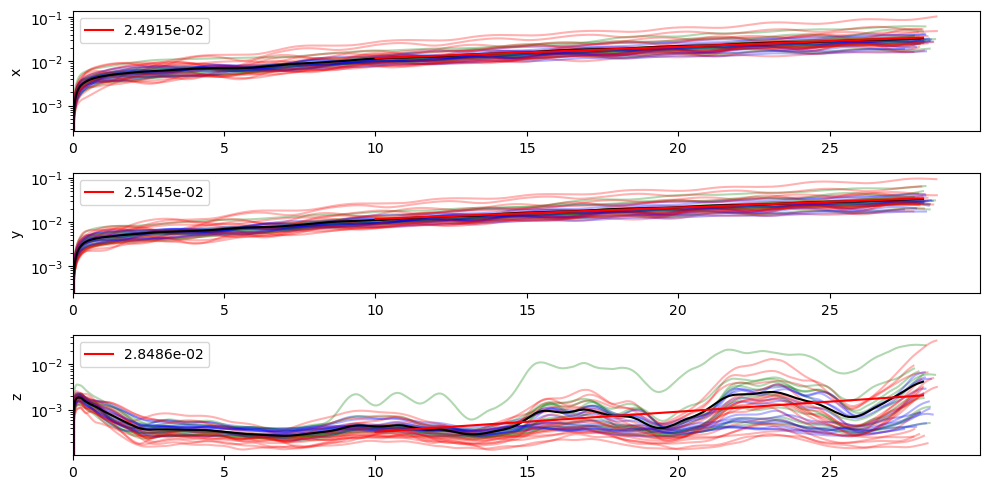

In [5]:
colors = {"rr": "r", "er": "g", "ba": "b"}
fit_range, yscale = 10.0, "log"

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 5), nrows=3)

slopes1, slopes2, slopes3 = [], [], []
for network_type, sample_time, sample_mae in zip(test_df.network_type, times, maes):
    color = colors[network_type]
    plot_trajectory(
        # ax1, ax2, ax3, sample_mae[:, None, :], time=sample_time, alpha=0.3, color="gray"
        ax1, ax2, ax3, sample_mae[:, None, :], time=sample_time, alpha=0.3, color=color
    )

    mask = sample_time > fit_range
    if yscale == "log":
        *_, slope1, _ = fitting.lin_log_fit(sample_time[mask], sample_mae[mask, 0])
        *_, slope2, _ = fitting.lin_log_fit(sample_time[mask], sample_mae[mask, 1])
        *_, slope3, _ = fitting.lin_log_fit(sample_time[mask], sample_mae[mask, 2])
    else:
        *_, slope1, _ = fitting.lin_fit(sample_time[mask], sample_mae[mask, 0])
        *_, slope2, _ = fitting.lin_fit(sample_time[mask], sample_mae[mask, 1])
        *_, slope3, _ = fitting.lin_fit(sample_time[mask], sample_mae[mask, 2])
    slopes1.append(slope1)
    slopes2.append(slope2)
    slopes3.append(slope3)

final_mae = np.mean(maes, 0)
t = np.linspace(0.0, np.mean(times[:, -1]), times.shape[1], dtype=np.float32)
plot_trajectory(ax1, ax2, ax3, final_mae[:, None, :], time=t, color="k")

mask = t > fit_range
if yscale == "log":
    fit_t1, fit_mae1, slope1, _ = fitting.lin_log_fit(t[mask], final_mae[mask, 0])
    fit_t2, fit_mae2, slope2, _ = fitting.lin_log_fit(t[mask], final_mae[mask, 1])
    fit_t3, fit_mae3, slope3, _ = fitting.lin_log_fit(t[mask], final_mae[mask, 2])
else:
    fit_t1, fit_mae1, slope1, _ = fitting.lin_fit(t[mask], final_mae[mask, 0])
    fit_t2, fit_mae2, slope2, _ = fitting.lin_fit(t[mask], final_mae[mask, 1])
    fit_t3, fit_mae3, slope3, _ = fitting.lin_fit(t[mask], final_mae[mask, 2])
ax1.plot(fit_t1, fit_mae1, "r-", label=f"{np.mean(slopes1):.4e}")
ax2.plot(fit_t2, fit_mae2, "r-", label=f"{np.mean(slopes2):.4e}")
ax3.plot(fit_t3, fit_mae3, "r-", label=f"{np.mean(slopes3):.4e}")

print(f"x slope: {np.mean(slopes1):.4e} pm {np.std(slopes1):.4e}")
print(f"x slope of averaged curve: {slope1:.4e}")
ax1.legend()
ax1.set_xlim(left=0.0)

print(f"y slope: {np.mean(slopes2):.4e} pm {np.std(slopes2):.4e}")
print(f"y slope of averaged curve: {slope2:.4e}")
ax2.legend()
ax2.set_xlim(left=0.0)

print(f"z slope: {np.mean(slopes3):.4e} pm {np.std(slopes3):.4e}")
print(f"z slope of averaged curve: {slope3:.4e}")
ax3.legend()
ax3.set_xlim(left=0.0)

if yscale == "log":
    ax1.set_yscale("log")
    ax2.set_yscale("log")
    ax3.set_yscale("log")

fig.tight_layout()
# fig.savefig(f"{FIG_DIR}/rossler_xyz_mae.pdf", bbox_inches="tight", pad_inches=0.0)
fig.show()

slope: 2.2963e-02 pm 5.0669e-03
slope of averaged curve: 2.3790e-02


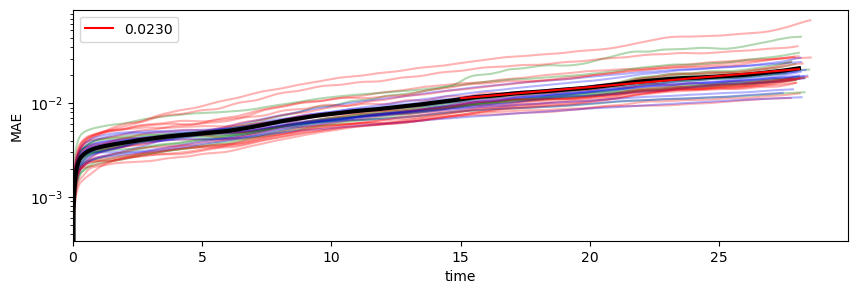

In [7]:
colors = {"rr": "r", "er": "g", "ba": "b"}
fit_range, yscale = 15.0, "log"

fig, ax = plt.subplots(figsize=(10, 3))

slopes = []
for network_type, sample_time, sample_mae in zip(test_df.network_type, times, np.mean(maes, -1)):
    # ax.plot(sample_time, sample_mae, alpha=0.3, color="gray")
    ax.plot(sample_time, sample_mae, alpha=0.3, color=colors[network_type])

    mask = sample_time > fit_range
    if yscale == "log":
        *_, slope, _ = fitting.lin_log_fit(sample_time[mask], sample_mae[mask])
    else:
        *_, slope, _ = fitting.lin_fit(sample_time[mask], sample_mae[mask])
    slopes.append(slope)

final_mae = np.mean(maes, (0, 2))
t = np.linspace(0.0, np.mean(times[:, -1]), times.shape[1], dtype=np.float32)
ax.plot(t, final_mae, "k-", linewidth=3)

mask = t > fit_range
if yscale == "log":
    fit_t, fit_mae, slope, _ = fitting.lin_log_fit(t[mask], final_mae[mask])
else:
    fit_t, fit_mae, slope, _ = fitting.lin_fit(t[mask], final_mae[mask])
print(f"slope: {np.mean(slopes):.4e} pm {np.std(slopes):.4e}")
print(f"slope of averaged curve: {slope:.4e}")
ax.plot(fit_t, fit_mae, "r-", label=f"{np.mean(slopes):.4f}")
ax.legend()

if yscale == "log":
    ax.set_yscale("log")
ax.set_xlim(left=0)
ax.set_xlabel("time")
ax.set_ylabel("MAE")

# fig.savefig(f"{FIG_DIR}/rossler_mae.pdf", bbox_inches="tight", pad_inches=0.0)
fig.show()

# Order difference

In [61]:
df1 = pd.read_pickle(DATA_DIR / "rossler_O1.pkl")
pred_trajectories = [traj.numpy() for traj in df1.trajectories]
df4 = pd.read_pickle(DATA_DIR / "rossler_O4.pkl")
true_trajectories = [traj.numpy() for traj in df4.trajectories]
maes = [compare_trajectory(true, pred) for true, pred in zip(pred_trajectories, true_trajectories)]
times = [np.append(0, np.cumsum(dt.numpy())) for dt in df1.dts]


MAE: 0.6474, Maximum err: 30.6082 at step=634, node=4221, coordinate=z
MAE: 0.6357, Maximum err: 21.9778 at step=800, node=7218, coordinate=z
MAE: 0.4638, Maximum err: 8.1174 at step=799, node=8456, coordinate=z
MAE: 0.3278, Maximum err: 3.4698 at step=800, node=9489, coordinate=x
MAE: 0.8529, Maximum err: 41.3888 at step=669, node=572, coordinate=z
MAE: 0.4546, Maximum err: 7.7709 at step=643, node=8074, coordinate=z
MAE: 0.4543, Maximum err: 8.5763 at step=657, node=9963, coordinate=z
MAE: 0.4146, Maximum err: 5.2201 at step=797, node=7525, coordinate=z
MAE: 0.6913, Maximum err: 18.7534 at step=788, node=5312, coordinate=z
MAE: 0.3977, Maximum err: 7.0384 at step=663, node=4390, coordinate=z
MAE: 0.6367, Maximum err: 18.2071 at step=796, node=3465, coordinate=z
MAE: 0.7767, Maximum err: 27.0476 at step=795, node=1754, coordinate=z
MAE: 0.3963, Maximum err: 15.1663 at step=634, node=6875, coordinate=z
MAE: 0.3664, Maximum err: 7.1307 at step=796, node=2723, coordinate=z
MAE: 0.2482, M

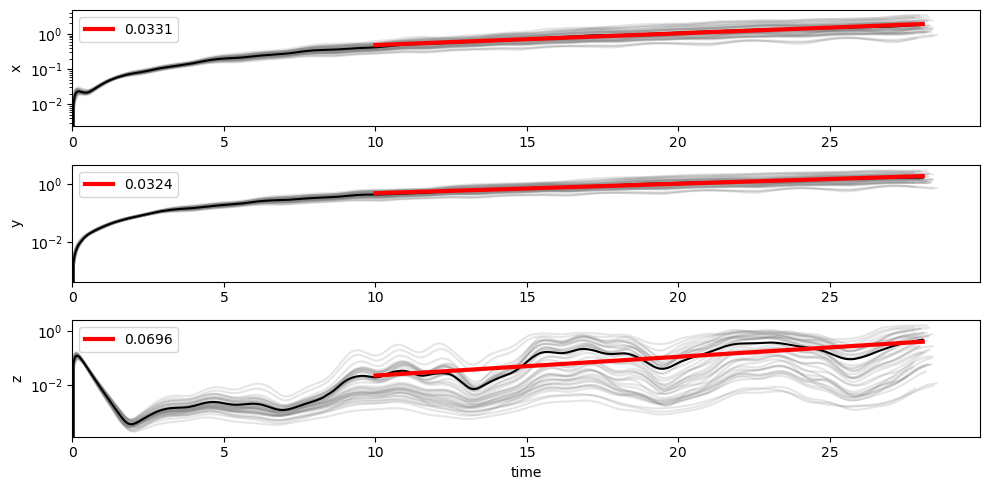

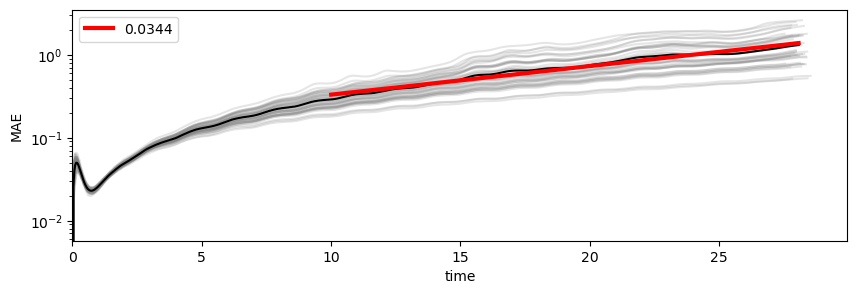

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 5), nrows=3)

for sample_time, sample_mae in zip(times, maes):
    plot_trajectory(ax1, ax2, ax3, sample_mae[:, None, :], time=sample_time, alpha=0.2, color="gray")


t = np.linspace(0.0, sum(t[-1] for t in times) / len(times), len(times[0]), dtype=np.float32)
mask = t > 10.0
final_mae = np.mean(maes, axis=0)
plot_trajectory(ax1, ax2, ax3, final_mae[:, None, :], time=t, color="k")

fit_t1, fit_mae1, slope1, _ = fitting.lin_log_fit(t[mask], final_mae[mask, 0])
ax1.plot(fit_t1, fit_mae1, color="red", label=f"{slope1:.4e}", linewidth=3)
ax1.legend()
ax1.set_yscale("log")
ax1.set_xlim(left=0.0)

fit_t2, fit_mae2, slope2, _ = fitting.lin_log_fit(t[mask], final_mae[mask, 1])
ax2.plot(fit_t2, fit_mae2, color="red", label=f"{slope2:.4e}", linewidth=3)
ax2.legend()
ax2.set_yscale("log")
ax2.set_xlim(left=0.0)

fit_t3, fit_mae3, slope3, _ = fitting.lin_log_fit(t[mask], final_mae[mask, 2])
ax3.plot(fit_t3, fit_mae3, color="red", label=f"{slope3:.4e}", linewidth=3)
ax3.legend()
ax3.set_yscale("log")
ax3.set_xlabel("time")
ax3.set_xlim(left=0.0)

fig.tight_layout()
fig.show()


fig, ax = plt.subplots(figsize=(10, 3))

for sample_time, sample_mae in zip(times, np.mean(maes, -1)):
    ax.plot(sample_time, sample_mae, alpha=0.2, color="gray")

t = np.linspace(0.0, sum(t[-1] for t in times) / len(times), len(times[0]), dtype=np.float32)
mask = t > 10.0
final_mae = np.mean(maes, axis=(0, 2))
ax.plot(t, final_mae, "k-")

fit_t, fit_mae, slope, _ = fitting.lin_log_fit(t[mask], final_mae[mask])
ax.plot(fit_t, fit_mae, color="red", label=f"{slope:.4e}", linewidth=3)
ax.legend()
ax.set_yscale("log")
ax.set_xlim(left=0)
ax.set_xlabel("time")
ax.set_ylabel("MAE")

fig.show()